In [185]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from os.path import join as oj
from copy import deepcopy
import pandas as pd
from numpy import array as arr
import time
sys.path.append('../src')
import utils

# sklearn models
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree

import torch
from torch import nn

cred = (234/255, 51/255, 86/255)
cblue = (57/255, 138/255, 242/255)
out_dir = '../results/sim_linear'
os.makedirs(out_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
np.random.seed(13)
N = 300
p = 100
X = np.random.rand(N, p)
y = (X[:, 0] > 0.95).astype(np.int32)

# flip some points
num_to_flip = int(N * 0.08)
idxs = np.random.choice(N, num_to_flip, replace=False)
y[idxs] = 1 - y[idxs]
print('flipped', num_to_flip)

# plot the data
flipped = np.zeros(N, dtype=np.bool)
flipped[idxs] = 1
# plt.plot(X[~flipped, 0], y[~flipped], '.')
# plt.plot(X[flipped, 0], y[flipped], 'x')
plt.show()

flipped 24


/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


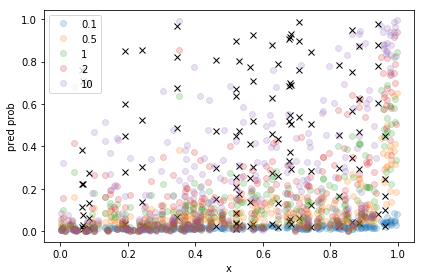

In [188]:
# X = np.random.rand(N, p)
# X[:, 0] = np.linspace(0, 1, N)
models = []
for class_weight in [0.1, 0.5, 1, 2, 10]:
    m = LogisticRegression(solver='lbfgs', random_state=13, class_weight={0: 1, 1: class_weight})
#     m = DecisionTreeClassifier(random_state=13, class_weight={0: 1, 1: class_weight})    
    m.fit(X, y)
    plt.plot(X[~flipped, 0], m.predict_proba(X)[~flipped, 1], 'o', label=str(class_weight), alpha=0.2)
    plt.plot(X[flipped, 0], m.predict_proba(X)[flipped, 1], 'x', color='black')
    models.append(deepcopy(m))
plt.xlabel('x')
plt.ylabel('pred prob')
plt.legend()
plt.tight_layout()

# generate uncertainty plots

In [189]:
m_diffident = models[1]
m_canonical  = models[2]
m_confident = models[3]
f = m_canonical.predict_proba

preds_diffident = m_diffident.predict_proba(X)
preds_canonical = m_canonical.predict_proba(X)
preds_confident = m_confident.predict_proba(X)

uncertainties_probit = (preds_confident - preds_diffident)[:, 1]

*look at flipped points*

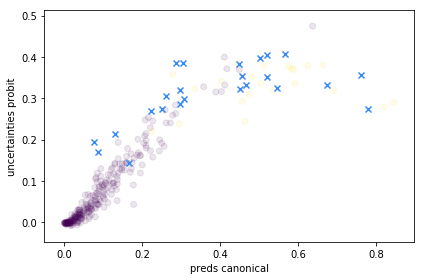

In [190]:
plt.scatter(preds_canonical[~flipped, 1], uncertainties_probit[~flipped], c=y[~flipped], alpha=0.1)
plt.scatter(preds_canonical[flipped, 1], uncertainties_probit[flipped], color=cblue, marker='x')
plt.xlabel('preds canonical')
plt.ylabel('uncertainties probit')
plt.tight_layout()
plt.savefig(oj(out_dir, 'check_flips.pdf'))

*uncertainty vs performance*

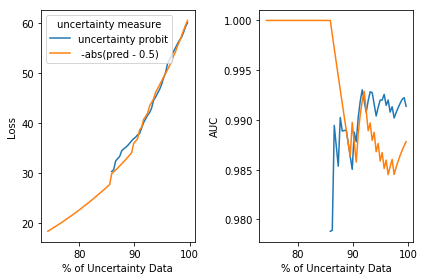

In [191]:
idxs = ~flipped
uncertainty_from_pred = -1 * np.abs(preds_canonical[:, 1] - 0.5)

percentages, performances = utils.get_performance_vs_uncertainty(y[idxs], preds_canonical[idxs], uncertainties_probit[idxs],
                                  y_axis_label='Loss', performance_fn_args={'reduction': 'sum'})
percentages_pred, performances_pred = utils.get_performance_vs_uncertainty(y[idxs], preds_canonical[idxs], uncertainty_from_pred[idxs],
                                  y_axis_label='Loss', performance_fn_args={'reduction': 'sum'})
# todo - add the other baseline (based on weights)

percentages_auc, performances_auc = utils.get_performance_vs_uncertainty(y[idxs], preds_canonical[idxs, 1], uncertainties_probit[idxs],
                                  y_axis_label='AUC', performance_fn=utils.roc_auc_score)    
percentages_auc_pred, performances_auc_pred = utils.get_performance_vs_uncertainty(y[idxs], preds_canonical[idxs, 1], uncertainty_from_pred[idxs],
                                  y_axis_label='AUC', performance_fn=utils.roc_auc_score)    

R, C = 1, 2
plt.subplot(R, C, 1)
plt.plot(percentages, performances, label='uncertainty probit')
plt.plot(percentages_pred, performances_pred, label=' -abs(pred - 0.5)')
plt.xlabel('% of Uncertainty Data')
plt.ylabel('Loss')
plt.legend(title='uncertainty measure')

plt.subplot(R, C, 2)
plt.plot(percentages_auc, performances_auc, label='uncertainty probit')
plt.plot(percentages_auc_pred, performances_auc_pred, label=' -abs(pred - 0.5)')
plt.xlabel('% of Uncertainty Data')
plt.ylabel('AUC')
# plt.legend(title='uncertainty measure')

plt.tight_layout()
plt.savefig(oj(out_dir, 'uncertainty_v_perf.pdf'))
plt.show()

*prediction calibration*

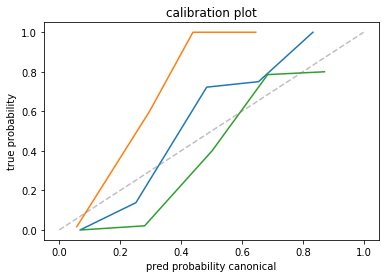

In [192]:
prob_true, prob_pred = calibration_curve(y[~flipped], preds_canonical[~flipped][:, 1], normalize=False, n_bins=5, strategy='uniform')
prob_true_d, prob_pred_d = calibration_curve(y[~flipped], preds_diffident[~flipped][:, 1], normalize=False, n_bins=5, strategy='uniform')
prob_true_c, prob_pred_c = calibration_curve(y[~flipped], preds_confident[~flipped][:, 1], normalize=False, n_bins=5, strategy='uniform')


plt.plot(prob_pred, prob_true)
plt.plot(prob_pred_d, prob_true_d)
plt.plot(prob_pred_c, prob_true_c)
plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)
plt.xlabel('pred probability canonical')
plt.ylabel('true probability')

plt.title('calibration plot')
plt.savefig(oj(out_dir, 'calibration.pdf'))
plt.show()

# model importances

*more flipping should lead to higher uncertainty, slightly worse estimates*

### step 1 - get ice plot

In [210]:
np.random.seed(13)
x = np.random.rand(1, p)

In [220]:
def get_grid_points(x, X, feature_num=0, strategy='linspace', num_grid_points=100):
    '''  
    Parameters
    ----------
    x : np.ndarray (1, num_features)
        Point to build ice curve
        
    '''
    X_new = np.repeat(x, num_grid_points, axis=0)    
    X_col = X[:, feature_num]
    if strategy == 'linspace':
        X_new[:, feature_num] = np.linspace(X_col.min(), X_col.max(), num_grid_points)
    return X_new
    

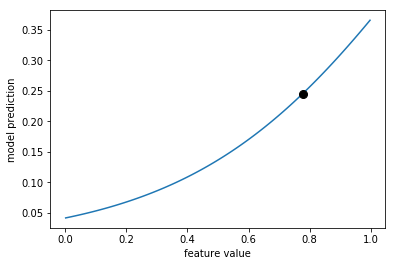

In [221]:
X_new = get_grid_points(x, X, feature_num=0)

### step 2 - do conditional sampling

In [226]:
def conditional_distr(x): return 1 / N

### step 3 - calculate contribution score

In [229]:
pred_mean = np.sum(f(X_new)[:, 1] * conditonal_distr(X_new[:, 0]))

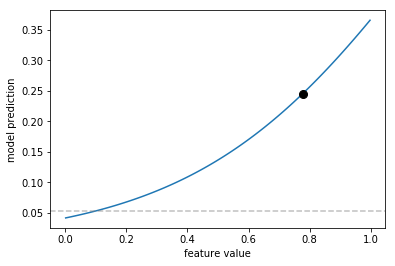

In [232]:
plt.plot(X_new[:, 0], f(X_new)[:, 1])
plt.plot(x[:, 0], f(x)[:, 1], 'o', color='black', ms=8)
plt.axhline(pred_mean, color='gray', alpha=0.5, linestyle='--')
plt.xlabel('feature value')
plt.ylabel('model prediction')
plt.show()

### step 4 - calculate sensitivity score